In [217]:
cd C:\Users\soumy\Downloads

C:\Users\soumy\Downloads


### Start by creating a new Environment

- To create an environment: `conda create --name anomalydetection python=3.7`
- Activate environment: `conda activate anomalydetection`

### Install the required packages (if required)

- `conda install jupyter`
- `conda install pandas`
- `conda install tensorflow`
- `conda install scikit-learn`
- `conda install plotly`
- `conda install matplotlib`

## Steps to follow for Anomaly Detection:
<ol>
<li>Construct an LSTM Autoencoder on the stock price data, assuming there are no anomalies.</li>
<li>Generate the error threshold on training dataset.</li>
<li>Detect Anomaly using the threshold on test dataset.</li>
</ol>


## Setup

In [218]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [219]:
df = pd.read_csv('GOOGL.csv')

## Quick look at data

In [220]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


**We will deal with the closing price for each day.**

In [221]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close']]

In [222]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4431 non-null   object 
 1   Close   4431 non-null   float64
dtypes: float64(1), object(1)
memory usage: 69.4+ KB


**Data Time Period**

In [223]:
df['Date'].min(), df['Date'].max()

('2004-08-19', '2022-03-24')

## Visualize the data

In [224]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Apple Inc. Stock Price 2004-2020')
fig.show()

## Data Preprocessing

#### 1. Train - test split

In [225]:
train = df.loc[df['Date'] <= '2016-12-24']
test = df.loc[(df['Date'] > '2016-12-24') & (df['Date'] < '2020-12-24')]
train.shape, test.shape


((3111, 2), (1006, 2))

#### 2. Data Scaling

In [226]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

C:\Users\soumy\AppData\Local\Temp\ipykernel_8960\3901342107.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\soumy\AppData\Local\Temp\ipykernel_8960\3901342107.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



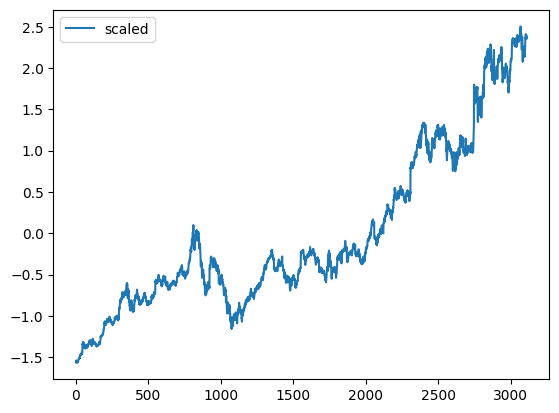

In [227]:
# Visualize scaled data
plt.plot(train['Close'], label = 'scaled')
plt.legend()
plt.show()

#### 3. Create sequences
- Create sequences combining `TIME_STEPS` contiguous data values from the training data.
- `TIME_STEP` is set 30 as we want our network to have memory of 30 days.

In [228]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (3081, 30, 1)
Testing input shape:  (976, 30, 1)


In [229]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

We are building LSTM Autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length is 30` and `num_features is 1`.

In [230]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_6 (RepeatVec  (None, 30, 128)           0         
 tor)                                                            
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_13 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_6 (TimeDi  (None, 30, 1)             129       
 stributed)                                           

## Train Model

In [231]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
87/87 [==============================] - 6s 35ms/step - loss: 0.0947 - val_loss: 0.1189
Epoch 2/100
87/87 [==============================] - 2s 27ms/step - loss: 0.0303 - val_loss: 0.0859
Epoch 3/100
87/87 [==============================] - 2s 29ms/step - loss: 0.0390 - val_loss: 0.0808
Epoch 4/100
87/87 [==============================] - 3s 30ms/step - loss: 0.0292 - val_loss: 0.0711
Epoch 5/100
87/87 [==============================] - 3s 29ms/step - loss: 0.0381 - val_loss: 0.0550
Epoch 6/100
87/87 [==============================] - 3s 30ms/step - loss: 0.0254 - val_loss: 0.0545
Epoch 7/100
87/87 [==============================] - 3s 29ms/step - loss: 0.0306 - val_loss: 0.0948
Epoch 8/100
87/87 [==============================] - 3s 30ms/step - loss: 0.0203 - val_loss: 0.0395
Epoch 9/100
87/87 [==============================] - 3s 29ms/step - loss: 0.0163 - val_loss: 0.0430
Epoch 10/100
87/87 [==============================] - 3s 31ms/step - loss: 0.0153 - val_loss: 0.0297

#### Plot Training - Validation loss

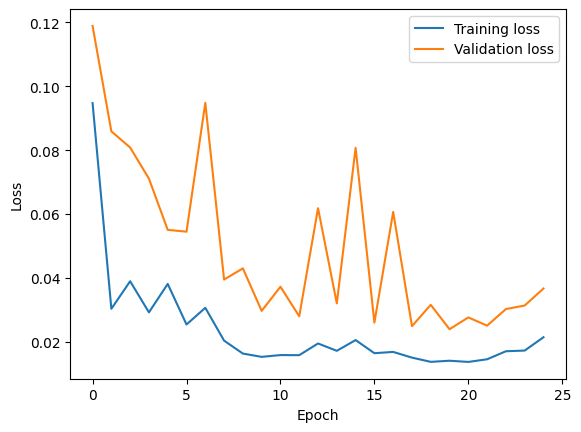

In [232]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

97/97 [==============================] - 2s 12ms/step
Reconstruction error threshold: 0.5404991534783228


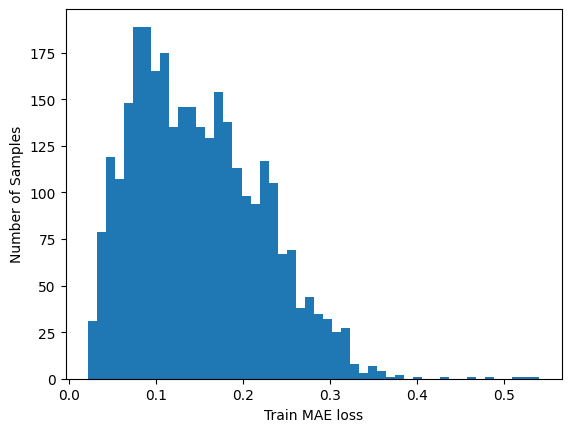

In [233]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)



### Reconstruction error threshold: 0.48992275269204094

## Predict Anomalies on test data using threshold

31/31 [==============================] - 0s 13ms/step


Text(0, 0.5, 'Number of samples')

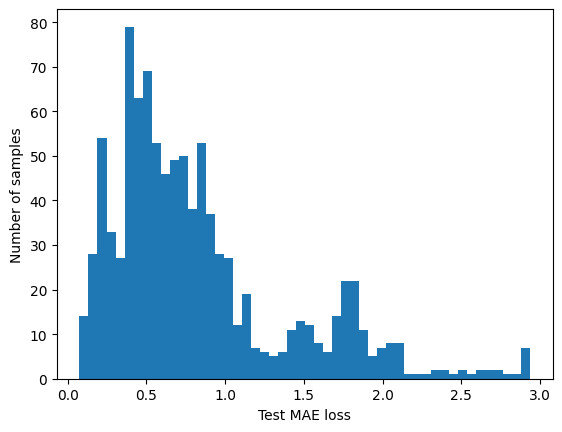

In [234]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [235]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [236]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
3141,2017-02-09,2.473938,0.170290,0.540499,False
3142,2017-02-10,2.498735,0.168294,0.540499,False
3143,2017-02-13,2.520013,0.165705,0.540499,False
3144,2017-02-14,2.525552,0.155037,0.540499,False
3145,2017-02-15,2.511523,0.153342,0.540499,False


In [237]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [238]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
3390,2018-02-06,3.790786,0.630078,0.540499,True
3391,2018-02-07,3.640552,0.672927,0.540499,True
3392,2018-02-08,3.393614,0.729794,0.540499,True
3393,2018-02-09,3.593235,0.815370,0.540499,True
3394,2018-02-12,3.636152,0.827701,0.540499,True


In [239]:
anomalies.shape

(598, 5)

In [240]:


fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close'].values.reshape(-1, 1)).flatten(), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close'].values.reshape(-1, 1)).flatten(), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()
